# Deep Learning Tutorial <br> Day 4. CIFAR10 Classification

Written by Nuri Kim.
This code can be downloaded from [GitHub](https://github.com/bareblackfoot/tf-tutorials).

References of this notebook: 
*TensorFlow-Tutorials by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)* and 
*CIFAR-10 by [dhanushkamath](https://github.com/dhanushkamath/CIFAR-10/blob/master/Cifar10.ipynb)*

## Introduction

This tutorial demonstrates the workflow of an image classification using TensorFlow with convolutional networks. Unlike MNIST dataset, CIFAR10 dataset has color images of 10 categories. Here, we define and optimize a simple mathematical model in TensorFlow. The results are then plotted.

## Imports

In [1]:
from glob import glob
from time import time
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
try:
    from urllib.request import urlretrieve
except:
    from urllib import urlretrieve
import pandas as pd
import numpy as np
import sys, os, math
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import itertools
import tarfile
import pickle

print ("Packages loaded")

Packages loaded


### Set parameters

In [2]:
# PARAMS
_BATCH_SIZE = 128
_EPOCH = 10
_SNAPSHOT_PREFIX = "cifar10"
_SAVE_PATH = "./output/cifar10/"
_NUM_VIS_EMBEDDING = 500
if not os.path.exists(_SAVE_PATH):
    os.makedirs(_SAVE_PATH)
_IMAGE_SIZE = 32
_IMAGE_CHANNELS = 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
_NUM_CLASSES = len(class_names)
class_to_num = dict(zip(class_names, range(_NUM_CLASSES)))
num_to_class = dict(zip(range(_NUM_CLASSES), class_names))

This was developed using Python 3.7 and TensorFlow version 1.10.0. Please check yours:

In [3]:
tf.__version__

'1.10.0'

### Helper-functions for loading images

Function used to download dataset and pre-process images.

In [4]:
def get_data_set(name="train"):
    x = y = None
    maybe_download_and_extract()
    folder_name = "cifar10"
    f = open('./data/'+folder_name+'/batches.meta', 'rb')
    f.close()

    if name is "train":
        for i in range(5):
            f = open('./data/'+folder_name+'/data_batch_' + str(i + 1), 'rb')
            try:
                datadict = pickle.load(f, encoding='latin1') 
            except:
                datadict = pickle.load(f)
            f.close()

            _X = datadict["data"]
            _Y = datadict['labels']

            _X = np.array(_X, dtype=float) / 255.0
            _X = _X.reshape([-1, _IMAGE_CHANNELS, _IMAGE_SIZE, _IMAGE_SIZE])
            _X = _X.transpose([0, 2, 3, 1])
            _X = _X.reshape(-1, _IMAGE_SIZE*_IMAGE_SIZE*_IMAGE_CHANNELS)

            if x is None:
                x = _X
                y = _Y
            else:
                x = np.concatenate((x, _X), axis=0)
                y = np.concatenate((y, _Y), axis=0)

    elif name is "test":
        f = open('./data/'+folder_name+'/test_batch', 'rb')
        try:
            datadict = pickle.load(f, encoding='latin1') 
        except:
            datadict = pickle.load(f)
        f.close()
        x = datadict["data"]
        y = np.array(datadict['labels'])
        x = np.array(x, dtype=float) / 255.0
        x = x.reshape([-1, _IMAGE_CHANNELS, _IMAGE_SIZE, _IMAGE_SIZE])
        x = x.transpose([0, 2, 3, 1])
        x = x.reshape(-1, _IMAGE_SIZE*_IMAGE_SIZE*_IMAGE_CHANNELS)

    return x, dense_to_one_hot(y)

def dense_to_one_hot(labels_dense, num_classes=10):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

def print_download_progress(count, block_size, total_size):
    pct_complete = float(count * block_size) / total_size
    msg = "\r- Download progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()
    
def maybe_download_and_extract():
    main_directory = "./data/"
    if not os.path.exists(main_directory):
        os.makedirs(main_directory)
    cifar_10_directory = main_directory+"cifar10/"
    if not os.path.exists(cifar_10_directory):
        url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
        filename = url.split('/')[-1]
        file_path = os.path.join(main_directory, filename)
        zip_cifar_10 = file_path
        file_path, _ = urlretrieve(url=url, filename=file_path, 
                                   reporthook=print_download_progress)

        print()
        print("Download finished. Extracting files.")
        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode="r").extractall(main_directory)
        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode="r:gz").extractall(main_directory)
        print("Done.")

        os.rename(main_directory+"cifar-10-batches-py", cifar_10_directory)
        os.remove(zip_cifar_10)
        

## Load Data
The size of CIFAR10 dataset is about  180MB and it will be downloaded automatically if it is not located in the given path.

In [5]:

train_x, train_y = get_data_set("train")
test_x, test_y = get_data_set("test")

print ("Dataset loaded")

Dataset loaded


The CIFAR10 dataset has now been loaded and consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

### Plot a few images to see if data is correct

(50000, 3072)
(50000, 10)


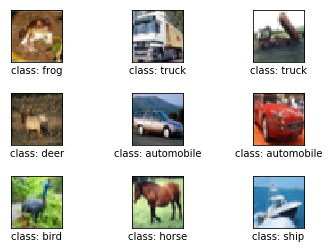

In [6]:
def show_images():
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.6, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(train_x[i].reshape(_IMAGE_SIZE, 
                                     _IMAGE_SIZE, _IMAGE_CHANNELS))
        
        # Name of the true class.
        cls_true_name = num_to_class[train_y[i].argmax()]
        xlabel = "class: {0}".format(cls_true_name)
        
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    return

print(train_x.shape)
print(train_y.shape)
show_images()

## TensorFlow Graph

The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) that are even faster than GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used to feed input into the graph.
* Model variables that are going to be optimized so as to make the model perform better.
* The model which is essentially just a mathematical function that calculates some output given the input in the placeholder variables and the model variables.
* A cost measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables of the model.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

In [7]:
def model():
    with tf.name_scope('main_params'):
        x = tf.placeholder(tf.float32, shape=[None, _IMAGE_SIZE * _IMAGE_SIZE * _IMAGE_CHANNELS], name='Input')
        y = tf.placeholder(tf.float32, shape=[None, _NUM_CLASSES], name='Output')
        keep_probability = tf.placeholder(tf.float32, shape=[], name='keep_prob')
        x_image = tf.reshape(x, [-1, _IMAGE_SIZE, _IMAGE_SIZE, _IMAGE_CHANNELS], name='images')

        global_step = tf.Variable(initial_value=0, trainable=False, name='global_step')
        learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')

    net = slim.repeat(x_image, 2, slim.conv2d, 32, [3, 3], scope='conv1')
    net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool1')
    net = slim.repeat(net, 2, slim.conv2d, 64, [3, 3], scope='conv2')
    net = slim.max_pool2d(net, [2, 2], padding='SAME', scope='pool2')
    net = slim.flatten(net, scope='flatten')
    net = slim.fully_connected(net, 1000, scope='fully_connected')
    net = slim.dropout(net, keep_probability, scope='dropout')
    feat = slim.fully_connected(net, _NUM_CLASSES, scope='feat', activation_fn=None)
    softmax = tf.nn.softmax(feat)

    y_pred_cls = tf.argmax(softmax, axis=1)

    return x, y, feat, softmax, y_pred_cls, global_step, learning_rate, keep_probability

def lr(epoch):
    learning_rate = 1e-3
    if epoch > 8:
        learning_rate *= 1e-2
    elif epoch > 5:
        learning_rate *= 1e-1
    return learning_rate

x, y, vis_embedding, output, y_pred_cls, global_step, learning_rate, keep_prob = model()

print ("Network ready")

Network ready


In [8]:
# LOSS AND OPTIMIZER
try:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=y))
except:
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y))
    
print('Loss is defined.')

Loss is defined.


### Optimization method

Now that we have a loss measure that must be minimized, we can then create an optimizer. In this case it is the basic form of Gradient Descent where the step-size is set to 0.01.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [9]:
global_accuracy = 0
epoch_start = 0

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,
                                   beta1=0.9,
                                   beta2=0.999,
                                   epsilon=1e-08).minimize(loss, global_step=global_step)

# PREDICTION AND ACCURACY CALCULATION
correct_prediction = tf.equal(y_pred_cls, tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))*100.0

print('Optimizer is defined')

Optimizer is defined


### Initialize network parameters

The variables for `weights` and `biases` must be initialized before we start optimizing them.

In [10]:
# SAVER
saver = tf.train.Saver()
sess = tf.Session()

try:
    print("Trying to restore last checkpoint ...")
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=_SAVE_PATH)
    saver.restore(sess, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
except ValueError:
    print("Initializing variables.")
    sess.run(tf.global_variables_initializer())

Trying to restore last checkpoint ...
Initializing variables.


### Helper-function to perform optimization iterations

Function for plotting confusion matrix and tsne examples of images.

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print('Drawing confusion matrix...')
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def plot_tsne(features, labels):
    numbered = LabelEncoder().fit_transform(list(labels))
    c = get_cmap(len(set(numbered)))
    colors=[]
    for num in numbered:
        temp=c(num)
        colors.append(temp)
        
    print('Fitting TSNE...')
    X_embedded = TSNE(n_components=2).fit_transform(features[:10000])
    X_embedded = np.array(X_embedded)
    vis_x = X_embedded[:, 0]
    vis_y = X_embedded[:, 1]
    numbered = LabelEncoder().fit_transform(list(labels))
    c = get_cmap(len(set(numbered)))
    plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(vis_x, vis_y, c=colors,alpha=1,linewidths=1,s=10, edgecolors='none')
    plt.show()
    return X_embedded

### Helper-function to test the model at the middle of training

In [15]:
def test_and_save(_global_step, epoch, feat, labels):
    global global_accuracy
    global epoch_start

    i = 0
    predicted_class = np.zeros(shape=len(test_x), dtype=np.int)
    random_test_predictions = np.zeros(shape=[len(test_x),3], dtype=np.int)
    while i < len(test_x):
        j = min(i + _BATCH_SIZE, len(test_x))
        batch_xs = test_x[i:j, :]
        batch_ys = test_y[i:j, :]
        random_test_predictions[i:j], predicted_class[i:j, :] = sess.run(
            [tf.nn.top_k(tf.nn.softmax(y_pred_cls)), y_pred_cls],
            feed_dict={x: batch_xs, y: batch_ys, learning_rate: lr(epoch), keep_prob: 1.0}
        )    
        i = j
    text_y_argmax = np.argmax(test_y, axis=1)  
    correct = (text_y_argmax == predicted_class)
    acc = correct.mean()*100
    correct_numbers = correct.sum()

    hours, rem = divmod(time() - epoch_start, 3600)
    minutes, seconds = divmod(rem, 60)
    mes = "\nEpoch {} - accuracy: {:.1f}% ({}/{}) - time: {:0>2}:{:0>2}:{:05.2f}"
    print(mes.format((epoch+1), acc, correct_numbers, len(test_x), int(hours), int(minutes), seconds))

    if global_accuracy != 0 and global_accuracy < acc:
        filename = _SNAPSHOT_PREFIX + '_epoch{:d}'.format(epoch) + '.ckpt'
        filename = os.path.join(_SAVE_PATH, filename)
        saver.save(sess, filename)

        mes = "This epoch receive better accuracy: {:.2f} > {:.2f}. Saving session..."
        print(mes.format(acc, global_accuracy))
        global_accuracy = acc

    elif global_accuracy == 0:
        global_accuracy = acc
        
    # Plot non-normalized confusion matrix
    cnf_matrix = confusion_matrix(text_y_argmax, predicted_class)
    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    plot_tsne(feat, labels)
    
    # Print Random Samples
    random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(feat, labels)), n_samples)))
    helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

    print("###########################################################################################################")

### Helper-function to perform optimization iterations

Function for performing a number of optimization iterations so as to gradually improve the `weights` and `biases` of the model. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples.

In [13]:
def train(epoch):
    global epoch_start
    epoch_start = time()
    batch_size = int(math.ceil(len(train_x) / _BATCH_SIZE))
    i_global = 0

    for s in range(batch_size):
        batch_xs = train_x[s*_BATCH_SIZE: (s+1)*_BATCH_SIZE]
        batch_ys = train_y[s*_BATCH_SIZE: (s+1)*_BATCH_SIZE]

        start_time = time()
        i_global, _, batch_loss, batch_acc = sess.run(
            [global_step, optimizer, loss, accuracy],
            feed_dict={x: batch_xs, y: batch_ys, learning_rate: lr(epoch), keep_prob: 0.5})
        duration = time() - start_time

        if s % 20 == 0:
            percentage = int(float(s)/float(batch_size)*100.0)
            bar_len = 29
            filled_len = int((bar_len*int(percentage))/100)
            bar = '=' * filled_len + '>' + '-' * (bar_len - filled_len)

            msg = "Global step: {:>5} - [{}] {:>3}% - accuracy: {:.1f}% - loss: {:.4f} - {:.1f} sample/sec"
            print(msg.format(i_global, bar, percentage, batch_acc, batch_loss, _BATCH_SIZE / duration))
    feat, labels = sess.run([vis_embedding, y], feed_dict={x: train_x[:_NUM_VIS_EMBEDDING], y: train_y[:_NUM_VIS_EMBEDDING], keep_prob: 1.0})
    labels = labels.argmax(1)

    test_and_save(i_global, epoch, feat, labels)

### Start training networks

Weights are optimized and the accuracy on the test set increases as global step increases.

In [16]:
print("Start training")
train_start = time()

for i in range(_EPOCH):
    print("\nEpoch: {}/{}\n".format((i+1), _EPOCH))
    train(i)

hours, rem = divmod(time() - train_start, 3600)
minutes, seconds = divmod(rem, 60)
mes = "Best accuracy pre session: {:.2f}, time: {:0>2}:{:0>2}:{:05.2f}"
print(mes.format(global_accuracy, int(hours), int(minutes), seconds))
print("Done training")

Start training

Epoch: 1/10

Global step:   392 - [>-----------------------------]   0% - accuracy: 44.5% - loss: 2.0059 - 25.9 sample/sec


KeyboardInterrupt: 